# Twitter-Sentimentanalyse

In [1]:
# Load (pre-cleaned) Sentiment140 training data set
rdd = sc.textFile("/user/cloudera/sentiment/training_cleaned.csv")

header = rdd.first()
rdd = rdd.filter(lambda line: line != header)
rdd = rdd.map(lambda line: line.split(","))
rdd.take(5)

[['awww that bummer you shoulda got david carr of third day to do it', '0'],
 ['is upset that he can not update his facebook by texting it and might cry as result school today also blah',
  '0'],
 ['dived many times for the ball managed to save the rest go out of bounds',
  '0'],
 ['my whole body feels itchy and like its on fire', '0'],
 ['no it not behaving at all mad why am here because can not see you all over there',
  '0']]

In [2]:
# Convert to Spark dataframe
from pyspark.sql.types import *

schema = StructType([
    StructField("text", StringType(), False), 
    StructField("sentiment", StringType(), False) 
    ])
df = sqlContext.createDataFrame(rdd, schema)
df = df.withColumn("label", df['sentiment'].cast(DoubleType()))
df.show(5)

+--------------------+---------+-----+
|                text|sentiment|label|
+--------------------+---------+-----+
|awww that bummer ...|        0|  0.0|
|is upset that he ...|        0|  0.0|
|dived many times ...|        0|  0.0|
|my whole body fee...|        0|  0.0|
|no it not behavin...|        0|  0.0|
+--------------------+---------+-----+
only showing top 5 rows



In [3]:
# Prepare training data using TF-IDF encoding
from pyspark.ml.feature import HashingTF, IDF, Tokenizer

tokenizer = Tokenizer(inputCol="text", outputCol="words")
wordsData = tokenizer.transform(df)
hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=100000)
featurizedData = hashingTF.transform(wordsData)
idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(featurizedData)
rescaledData = idfModel.transform(featurizedData)
rescaledData.show(5)

+--------------------+---------+-----+--------------------+--------------------+--------------------+
|                text|sentiment|label|               words|         rawFeatures|            features|
+--------------------+---------+-----+--------------------+--------------------+--------------------+
|awww that bummer ...|        0|  0.0|[awww, that, bumm...|(100000,[2540,321...|(100000,[2540,321...|
|is upset that he ...|        0|  0.0|[is, upset, that,...|(100000,[2311,312...|(100000,[2311,312...|
|dived many times ...|        0|  0.0|[dived, many, tim...|(100000,[1577,330...|(100000,[1577,330...|
|my whole body fee...|        0|  0.0|[my, whole, body,...|(100000,[3500,355...|(100000,[3500,355...|
|no it not behavin...|        0|  0.0|[no, it, not, beh...|(100000,[3116,312...|(100000,[3116,312...|
+--------------------+---------+-----+--------------------+--------------------+--------------------+
only showing top 5 rows



In [4]:
print(rescaledData.select('rawFeatures').take(1))
print(rescaledData.select('features').take(1))

[Row(rawFeatures=SparseVector(100000, {2540: 1.0, 3211: 1.0, 3371: 1.0, 3543: 1.0, 3707: 1.0, 7894: 1.0, 19839: 1.0, 31239: 1.0, 43278: 1.0, 46174: 1.0, 58580: 1.0, 58823: 1.0, 96672: 1.0, 99228: 1.0}))]
[Row(features=SparseVector(100000, {2540: 3.2873, 3211: 2.6964, 3371: 1.8062, 3543: 2.2371, 3707: 1.248, 7894: 6.6653, 19839: 1.876, 31239: 7.5145, 43278: 7.8091, 46174: 9.4389, 58580: 6.512, 58823: 2.3332, 96672: 6.9312, 99228: 2.9399}))]


In [5]:
# Split into training and test dataset
[trainingData, testData] = rescaledData.randomSplit([0.95, 0.05], seed = 2000)

In [6]:
# Model using classic logistic regression
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression()

# Fit the model
lrModel = lr.fit(trainingData)

In [7]:
# Apply model to test dataset
testPredictions = lrModel.transform(testData)
testPredictions.show(5)

/usr/lib/spark/python/pyspark/ml/classification.py:207: UserWarning: weights is deprecated. Use coefficients instead.
  warnings.warn("weights is deprecated. Use coefficients instead.")


+--------------------+---------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|                text|sentiment|label|               words|         rawFeatures|            features|       rawPrediction|         probability|prediction|
+--------------------+---------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|aa woo gutted tha...|        0|  0.0|[aa, woo, gutted,...|(100000,[3104,330...|(100000,[3104,330...|[1.11526984554556...|[0.75311026763160...|       0.0|
|    aaaa miss ya too|        0|  0.0|[aaaa, miss, ya, ...|(100000,[3848,150...|(100000,[3848,150...|[0.85075674508374...|[0.70072586292736...|       0.0|
|aaaaaa god can th...|        0|  0.0|[aaaaaa, god, can...|(100000,[571,1407...|(100000,[571,1407...|[1.81140526942755...|[0.85953162803086...|       0.0|
|aaaaaa my belly t...|        0|  0.0|[aaaaaa, my, bell...|(100000,[35

In [8]:
# Compute accuracy on test data
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="precision")
accuracy = evaluator.evaluate(testPredictions)
print("Test Accuracy = %g " % accuracy)

Test Accuracy = 0.787099 


In [9]:
# Retrain model on full dataset
lrModel = lr.fit(rescaledData)

In [10]:
# Load (pre-cleaned) Brexit dataset
rdd = sc.textFile("/user/cloudera/sentiment/brexit_cleaned.csv")

header = rdd.first()
rdd = rdd.filter(lambda line: line != header)
rdd = rdd.map(lambda line: line.split(","))
rdd.take(5)

[['those who died to protect democracy will be rolling in their graves vote brexit',
  '736284933686239233',
  '2016-05-27T19:56:22',
  'brexit'],
 ['this top swears if bollocks is good enough for angela eagle euref strongerin brexit brexin',
  '736284905710211073',
  '2016-05-27T19:56:15',
  'euref|strongerin|brexit|brexin'],
 ['dont the scots understand that joining the leaveeu side will give them more freedom than they have now brexit voteremain voteleave',
  '736284877084065792',
  '2016-05-27T19:56:08',
  'brexit|voteremain|voteleave'],
 ['the vision from enslaved brexit shut the door on europe the uk will become impoverished but it will be pure',
  '736284846151106563',
  '2016-05-27T19:56:01',
  'brexit'],
 ['it is not all about gdp and jobs we will adapt have the balls for brexit euref me happy via',
  '736284840992092160',
  '2016-05-27T19:56:00',
  'brexit|euref']]

In [11]:
# Convert to Spark dataframe
brexitSchema = StructType([
    StructField("text", StringType(), False), 
    StructField("id", StringType(), False),
    StructField("created", StringType(), False),
    StructField("hashtags", StringType(), False)
    ])
brexitData = sqlContext.createDataFrame(rdd, brexitSchema)
brexitData.show(5)

+--------------------+------------------+-------------------+--------------------+
|                text|                id|            created|            hashtags|
+--------------------+------------------+-------------------+--------------------+
|those who died to...|736284933686239233|2016-05-27T19:56:22|              brexit|
|this top swears i...|736284905710211073|2016-05-27T19:56:15|euref|strongerin|...|
|dont the scots un...|736284877084065792|2016-05-27T19:56:08|brexit|voteremain...|
|the vision from e...|736284846151106563|2016-05-27T19:56:01|              brexit|
|it is not all abo...|736284840992092160|2016-05-27T19:56:00|        brexit|euref|
+--------------------+------------------+-------------------+--------------------+
only showing top 5 rows



In [12]:
# Encode Brexit dataset using TF-IDF
brexitWordsData = tokenizer.transform(brexitData)
brexitFeaturizedData = hashingTF.transform(brexitWordsData)
brexitRescaledData = idfModel.transform(brexitFeaturizedData)
brexitRescaledData.show(5)

+--------------------+------------------+-------------------+--------------------+--------------------+--------------------+--------------------+
|                text|                id|            created|            hashtags|               words|         rawFeatures|            features|
+--------------------+------------------+-------------------+--------------------+--------------------+--------------------+--------------------+
|those who died to...|736284933686239233|2016-05-27T19:56:22|              brexit|[those, who, died...|(100000,[2405,313...|(100000,[2405,313...|
|this top swears i...|736284905710211073|2016-05-27T19:56:15|euref|strongerin|...|[this, top, swear...|(100000,[1577,335...|(100000,[1577,335...|
|dont the scots un...|736284877084065792|2016-05-27T19:56:08|brexit|voteremain...|[dont, the, scots...|(100000,[2326,927...|(100000,[2326,927...|
|the vision from e...|736284846151106563|2016-05-27T19:56:01|              brexit|[the, vision, fro...|(100000,[3139,337...|

In [13]:
# Apply model to Brexit data
brexitPredictions = lrModel.transform(brexitRescaledData)
brexitPredictions.show(5)

/usr/lib/spark/python/pyspark/ml/classification.py:207: UserWarning: weights is deprecated. Use coefficients instead.
  warnings.warn("weights is deprecated. Use coefficients instead.")


+--------------------+------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|                text|                id|            created|            hashtags|               words|         rawFeatures|            features|       rawPrediction|         probability|prediction|
+--------------------+------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|those who died to...|736284933686239233|2016-05-27T19:56:22|              brexit|[those, who, died...|(100000,[2405,313...|(100000,[2405,313...|[-0.3488333104539...|[0.41366536881981...|       1.0|
|this top swears i...|736284905710211073|2016-05-27T19:56:15|euref|strongerin|...|[this, top, swear...|(100000,[1577,335...|(100000,[1577,335...|[-1.5834556844937...|[0.17030662944834...|       1.0|
|dont

In [14]:
# Extract probability of positive sentiment
from pyspark.sql.functions import udf

brexitPredictions = brexitPredictions.withColumn("created", brexitPredictions['created'].cast(TimestampType()))

secondelement = udf(lambda v:float(v[1]),FloatType())
brexitSentiment = brexitPredictions.select('id', 'created', secondelement('probability'), 'hashtags')
brexitSentiment = brexitSentiment.withColumnRenamed(brexitSentiment.schema.names[2], 'sentiment')
brexitSentiment.show(5)

+------------------+--------------------+----------+--------------------+
|                id|             created| sentiment|            hashtags|
+------------------+--------------------+----------+--------------------+
|736284933686239233|2016-05-27 19:56:...|0.58633465|              brexit|
|736284905710211073|2016-05-27 19:56:...| 0.8296934|euref|strongerin|...|
|736284877084065792|2016-05-27 19:56:...| 0.7351543|brexit|voteremain...|
|736284846151106563|2016-05-27 19:56:...| 0.6074934|              brexit|
|736284840992092160|2016-05-27 19:56:...| 0.6154303|        brexit|euref|
+------------------+--------------------+----------+--------------------+
only showing top 5 rows



In [15]:
# Prepare for visualization using Spark SQL
brexitSentiment.registerTempTable('brexit_sentiment2')
brexitSentiment.cache()
df1 = sqlContext.sql("SELECT to_date(created) created_date, avg(sentiment) sentiment FROM brexit_sentiment2 GROUP BY to_date(created)")
df1.show(5)

+------------+------------------+
|created_date|         sentiment|
+------------+------------------+
|  2016-05-27|0.6159360325863231|
|  2016-05-28|0.6387453854432409|
|  2016-05-29|0.6235638685225119|
|  2016-05-30|0.6252476165017263|
|  2016-05-31| 0.611434574877216|
+------------+------------------+
only showing top 5 rows



Total number of tweets is 31 entries


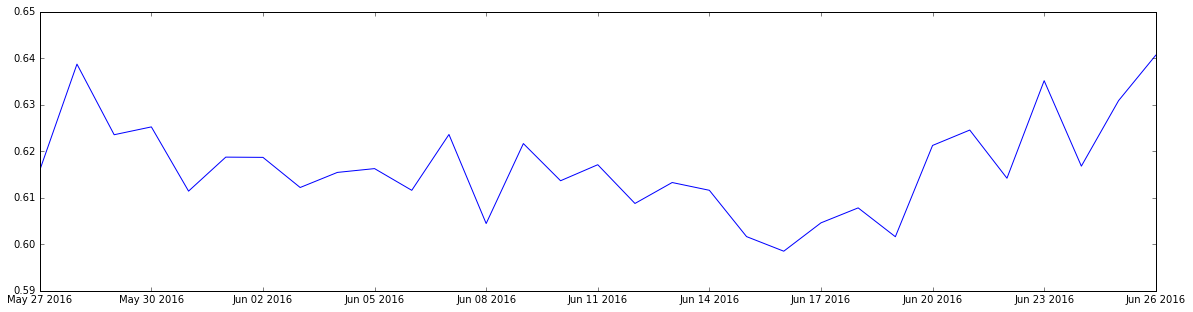

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

df2 = df1.toPandas()
df2['created_date'] = pd.to_datetime(df2['created_date'])

print("Total number of tweets is {0} entries".format(len(df2)))
plt.figure(figsize=(20,5))
plt.plot_date(df2['created_date'], df2['sentiment'], fmt='-')

In [17]:
# Extract only tweets with "Leave" hashtags
sql = ("SELECT to_date(created) created_date, avg(sentiment) sentiment FROM brexit_sentiment2 "
       "WHERE (hashtags like '%leave%' OR hashtags like '%takecontrol%' or hashtags like '%voteout%') "
       "AND NOT (hashtags like '%remain%' OR hashtags like '%strongerin%' or hashtags like '%votein%') "
       "GROUP BY to_date(created)")
dfLeave = sqlContext.sql(sql)
dfLeave2 = dfLeave.toPandas()

In [18]:
# Extract only tweets with "Remain" hashtags 
sql = ("SELECT to_date(created) created_date, avg(sentiment) sentiment FROM brexit_sentiment2 "
       "WHERE (hashtags like '%remain%' OR hashtags like '%strongerin%' or hashtags like '%votein%') "
       "AND NOT (hashtags like '%leave%' OR hashtags like '%takecontrol%' or hashtags like '%voteout%') "
       "GROUP BY to_date(created)")
dfRemain = sqlContext.sql(sql)
dfRemain2 = dfRemain.toPandas()

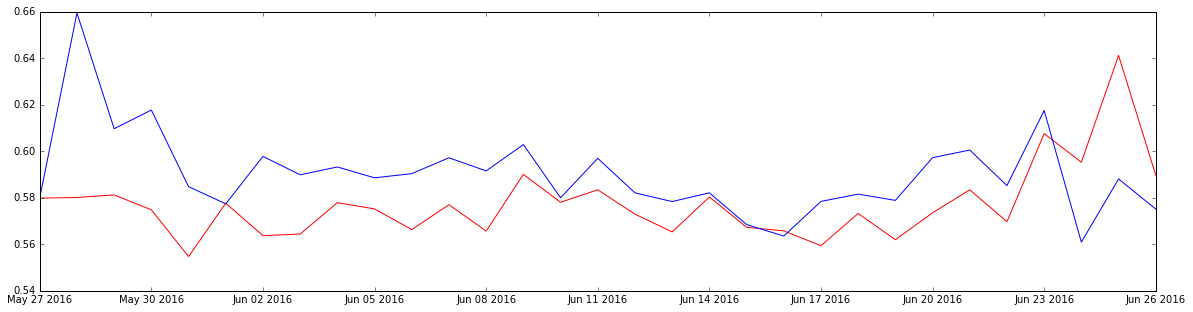

In [19]:
plt.figure(figsize=(20,5))
plt.plot_date(dfLeave2['created_date'], dfLeave2['sentiment'], fmt='-', color='red')
plt.plot_date(dfRemain2['created_date'], dfRemain2['sentiment'], fmt='-', color='blue')